In [1]:
!pip install apache_beam numpy pandas matplotlib scikit-learn

# **<h1 align="center">Projet `Big Data`</h1>**

<h2 align="center">🤖 SALHI Youssef | LABRIJI Saad 🤖</h2>
<h3 align="center"><code>AMSD</code> | <code>MLSD</code></h3>

    
## Objectif du Projet
Le projet vise à étudier différentes méthodes pour traiter de grandes quantités de données sans pouvoir les charger en mémoire sur une seule machine. L'objectif principal est de classifier ces données de manière non supervisée à l'aide de l'algorithme K-means. Chaque partie du projet représente une approche distincte pour l'implémentation de K-means, adaptée à des contraintes spécifiques. Aucune de ces approches n'est universellement supérieure, car elles font des choix différents pour répondre à des besoins particuliers.

## Composantes du Projet

Les sections que nous aborderons dans ce projet sont :

* `K-Means Séquentiel en Python` : Développer un modèle de Clustring basé sur Python.
* `K-Means en Flux en Python` : Adapter pour les flux de données dynamiques.
* `Apache Beam pour la Scalabilité` : Traitement efficace de grands ensembles de données.

## Importation des librairies nécessaires




In [2]:
# Standard Libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For plotting
import math  # For calculus
import random  # For generating random numbers

# Machine Learning Libraries
from sklearn.cluster import KMeans  # For K-Means clustering

# Apache Beam Imports
import apache_beam as beam  # Apache Beam framework
from apache_beam.transforms.core import CombinePerKey  # For Combine per key operation
from apache_beam.transforms import Map  # For the Map transform
from apache_beam.transforms.userstate import BagStateSpec  # For defining Bag State Spec
from apache_beam.transforms.window import FixedWindows  # For FixedWindows in windowing

## A. Implémentation de K-Means Séquentiel

### 1. Génération d'un Jeu de Données

Dans cette étape, nous allons créer un jeu de données composé de points répartis en deux classes distinctes. Chacune de ces classes contiendra 100 points regroupés autour d'un centroïde spécifique. La première classe sera centrée aux coordonnées (5, 5) tandis que la deuxième sera centrée autour de (10, 10). Ces données seront ensuite enregistrées au format CSV dans un fichier nommé **`generated_data.csv`** pour une utilisation future.

In [3]:
# Set the seed for reproducibility
np.random.seed(0)

# Define the number of points per class
n_points = 100

# Define the centroids for each class
centroid1 = (5, 5)
centroid2 = (10, 10)

# Generate points around each centroid ; using a normal distribution with a standard deviation of 1
points_class1 = np.random.normal(centroid1, 1, (n_points, 2))
points_class2 = np.random.normal(centroid2, 1, (n_points, 2))

# Combine the points from both classes
data = np.vstack((points_class1, points_class2))

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data, columns=['x', 'y'])

# Save the data to a CSV file
csv_file = 'generated_data.csv'
df.to_csv(csv_file, index=False)

Les données ont été générées et enregistrées dans un fichier CSV nommé `generated_data.csv`. Chaque point est caractérisé par deux coordonnées (x, y). Ce fichier sera utilisé pour les étapes suivantes de l'implémentation du k-means.


### 2. Lecture des données en consommant peu de mémoire

Lorsque nous travaillons avec de grands ensembles de données, il est crucial de gérer efficacement l'utilisation de la mémoire. Pandas offre plusieurs options pour réduire la consommation de mémoire lors de la lecture de fichiers. Nous allons utiliser ces techniques pour lire le fichier CSV contenant nos données de manière efficace en mémoire.


In [4]:
# Read the CSV file with specified data types
df = pd.read_csv(csv_file, dtype={'x': 'float32', 'y': 'float32'})
# By default, pandas casts data to 'float64'; using 'float32' to save memory.

# Display the initial records of the DataFrame
df.head(3)

,x,y
0,6.764052,5.400157
1,5.978738,7.240893
2,6.867558,4.022722


## 3. Implémenter l'algorithme k-means séquentiel en Python

Après avoir généré et lu les données, nous allons maintenant implémenter l'algorithme **k-means de manière séquentielle**. Cela implique de choisir de manière aléatoire les premiers centres de clusters et de mettre à jour ces centres au fur et à mesure que nous parcourons chaque point de données.


In [5]:
def sequential_kmeans(data, k=2, epochs=1):
    """
    Implement the sequential k-means algorithm.

    Parameters:
    data : numpy.ndarray ; The dataset to be clustered, where each row is a data point.
    k : int, default 2 ; The number of clusters to form.
    epochs : int, default 1 ; The number of passes over the dataset.

    Returns:
    centers : numpy.ndarray ; The final cluster centers.
    """
    # Randomly choose k data points as initial cluster centers
    centers = data[np.random.choice(data.shape[0], k, replace=False)]
    # Initialize the effective count of data points for each cluster
    counts = np.zeros(k)

    # Loop over the dataset for the given number of epochs
    for _ in range(epochs):
        for x in data:
            # Calculate the distance from the point to each cluster center
            distances = np.linalg.norm(x - centers, axis=1)
            # Identify the closest cluster center
            closest_center_idx = np.argmin(distances)
            # Update the effective count for this cluster
            counts[closest_center_idx] += 1
            # Update the cluster center by calculating the new mean
            eta = 1 / counts[closest_center_idx]
            centers[closest_center_idx] += eta * (x - centers[closest_center_idx])

    return centers

Le code fourni met en œuvre l'algorithme séquentiel k-means, qui procède par l'ajustement progressif des centres des clusters. À chaque itération, l'algorithme attribue chaque point de données au centre le plus proche, puis met à jour la position de ce centre en fonction de la moyenne des points qui lui ont été assignés. Cette méthode permet aux centres de s'adapter dynamiquement, reflétant la distribution sous-jacente des données.

In [6]:
# Execute the sequential k-means algorithm
data = df[['x', 'y']].to_numpy()
final_centers = sequential_kmeans(data, k=2, epochs=1)
final_centers

array([[4.9990435, 5.14278  ],
       [9.856923 , 9.887048 ]], dtype=float32)



Après avoir exécuté l'algorithme pour une seule époque, les résultats montrent que les centres des clusters ont convergé vers des valeurs qui reflètent étroitement les centroïdes autour desquels les données ont été initialement simulées :

- Centre du premier cluster : (4.999, 5.143)
- Centre du deuxième cluster : (9.857, 9.887)

Ces résultats sont cohérents avec nos attentes, étant donné les centroïdes théoriques de (5, 5) et (10, 10). L'approximation précise des positions des centres indique une bonne performance de l'algorithme et une adaptation correcte aux caractéristiques de notre jeu de données.


## 4. Enregistrer les résultats de l'algorithme

Il est important d'enregistrer les résultats de l'algorithme de manière efficace, particulièrement dans le contexte du **Big Data** où la gestion de la mémoire est critique. Nous allons donc enregistrer les centres des clusters dans un fichier texte léger.

In [7]:
# Convert the final cluster centers to a pandas DataFrame
centers_df = pd.DataFrame(final_centers, columns=['x_center', 'y_center'])

# Save the cluster centers to a CSV file, minimizing memory usage
centers_csv_file = 'cluster_centers.csv'
centers_df.to_csv(centers_csv_file, index=False, float_format='%.3f')

## 5. Valider la cohérence des résultats

Pour s'assurer de la cohérence des résultats de l'algorithme k-means, nous pouvons visualiser les clusters ainsi que les centres calculés. De plus, l'utilisation de mesures d'évaluation telles que la somme des carrés des distances (WCSS) peut aider à évaluer la qualité du clustering.


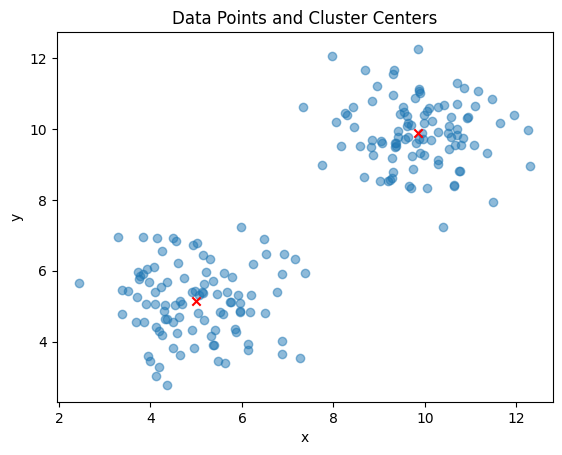

In [8]:
# Visualize the data points and the calculated cluster centers
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
plt.scatter(final_centers[:, 0], final_centers[:, 1], color='red', marker='x')
plt.title('Data Points and Cluster Centers')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## B. Implémentation d'une version streaming de k-means

L'algorithme streaming de k-means adapté tient compte de la pondération des données en fonction de leur ancienneté dans le flux. Les points de données plus anciens ont moins d'influence sur la position des centres des clusters, permettant à l'algorithme de s'adapter plus rapidement aux changements de données (concept drift).


In [9]:
def streaming_kmeans(batches, new_batch, initial_centroids, r=0.9, T=5, k=2):
    # Trim the batches list to maintain a maximum of T batches
    batches = [(batch, age) for batch, age in batches if age < T-1]
    # Add new batch with age 0
    batches.append((new_batch, 0))

    # Prepare weighted data and weights for k-means
    weighted_data = np.vstack([batch for batch, _ in batches])
    # Apply decay to the batch weights
    weights = np.hstack([(r**age) * np.ones(len(batch)) for batch, age in batches])

    # Initialize k-means with the provided centroids if they are given, else random
    init = initial_centroids if initial_centroids is not None and len(initial_centroids) == k else 'random'
    # Run weighted k-means
    kmeans = KMeans(n_clusters=k, init=init, n_init=1, max_iter=300)
    kmeans.fit(weighted_data, sample_weight=weights)

    return kmeans.cluster_centers_

Cette fonction `streaming_kmeans` utilise une liste de tuples pour gérer l'historique des lots avec leur âge. Chaque lot est pondéré selon une décroissance exponentielle basée sur son âge et le taux de décroissance `r`. En utilisant la méthode `fit` de l'objet `KMeans` de scikit-learn, nous intégrons ces poids pour ajuster les centres de clusters en fonction de l'évolution des données.


### Exemple d'utilisation de la fonction `streaming_kmeans`

Nous allons simuler un flux de données et mettre à jour les centres de clusters en utilisant la fonction `streaming_kmeans`. Pour valider visuellement, nous afficherons les centres de clusters avant et après la mise à jour.


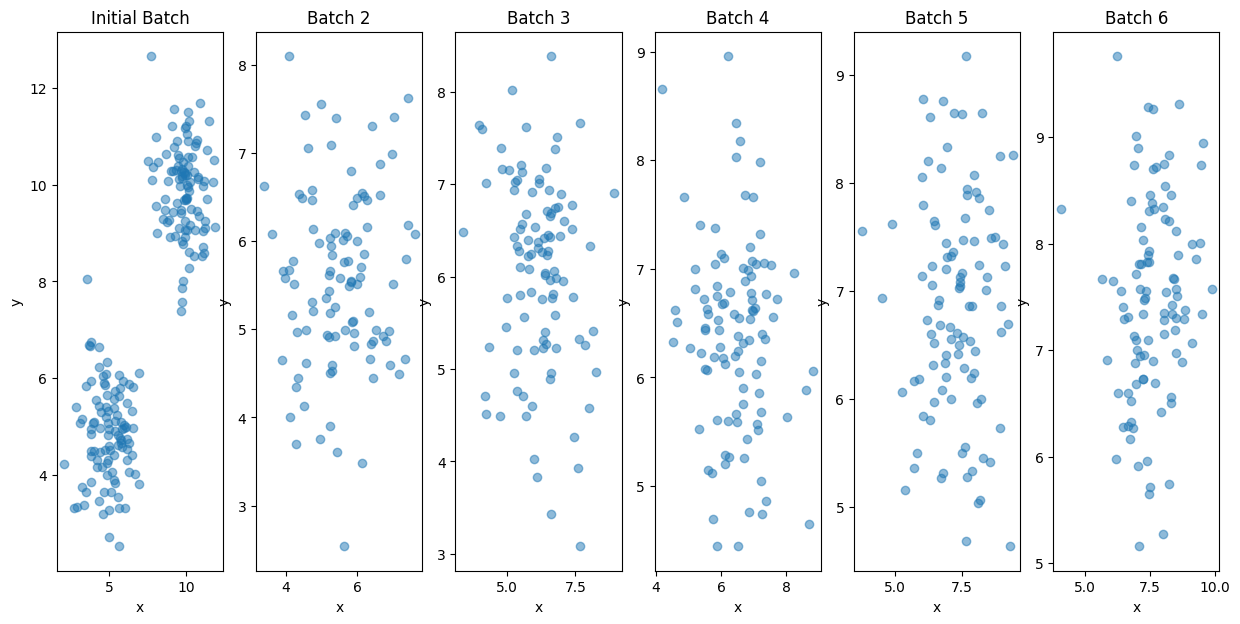

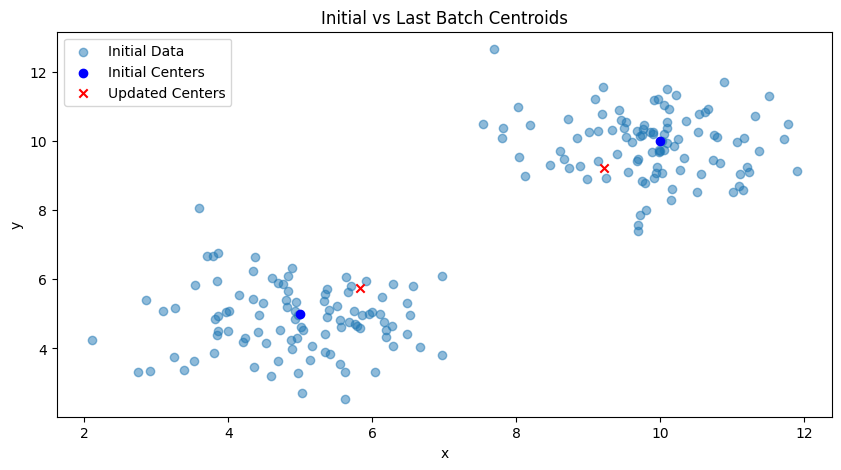

In [10]:
def streaming_kmeans_simulation():
    drift_amount = 0.5  # Smaller drift amount for more subtle change

    # Generate initial data for two clusters
    data_cluster_1 = np.random.normal(loc=[5, 5], scale=1.0, size=(100, 2))
    data_cluster_2 = np.random.normal(loc=[10, 10], scale=1.0, size=(100, 2))
    initial_data = np.vstack((data_cluster_1, data_cluster_2))

    batches = [(initial_data, 0)]  # Start with the initial data
    initial_centroids = np.array([[5, 5], [10, 10]])  # Assume accurate initial centroids

    # Simulate streaming data with new batches
    for i in range(1, 6):  # Simulate 5 new batches
        new_batch = np.random.normal(loc=[5 + drift_amount * i, 5 + drift_amount * i], scale=1.0, size=(100, 2))
        batches.append((new_batch, i))  # Add new batch with the drift

    # Plot all batches
    plt.figure(figsize=(15, 7))
    for i, (batch, _) in enumerate(batches):
        plt.subplot(1, len(batches), i+1)
        plt.scatter(batch[:, 0], batch[:, 1], alpha=0.5)
        if i == 0:
            plt.title('Initial Batch')
        else:
            plt.title(f'Batch {i+1}')
        plt.xlabel('x')
        plt.ylabel('y')

    # Plot the evolution of centroids
    plt.figure(figsize=(10, 5))

    # Plot the initial centroids
    plt.scatter(initial_data[:, 0], initial_data[:, 1], alpha=0.5, label='Initial Data')
    plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], color='blue', marker='o', label='Initial Centers')

    # Update centroids with each batch and plot
    for batch, _ in batches:
        initial_centroids = streaming_kmeans(batches, batch, initial_centroids, r=0.9, T=5, k=2)
    plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], color='red', marker='x', label='Updated Centers')

    plt.title('Initial vs Last Batch Centroids')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

streaming_kmeans_simulation()

Les résultats montrent une série de lots de données (de l'Initial à Batch 6) où l'on peut observer un léger déplacement des points de données au fil du temps, suggérant une évolution ou un concept drift dans les données. La dernière image représente à la fois le lot initial et le dernier lot avec les centres initiaux et mis à jour. Les centroïdes mis à jour semblent avoir légèrement bougé par rapport aux centres initiaux, ce qui indique que l'algorithme de k-means en streaming a ajusté les centres des clusters pour s'adapter à la nouvelle distribution des données. Cela illustre l'objectif de l'algorithme streaming k-means, qui est d'adapter les clusters au fur et à mesure que de nouvelles données arrivent, en tenant compte de la dérive dans l'espace des caractéristiques.

## C. Implémentation de k-means distribué (Apache Beam)



In [11]:
def kmeans(points, k):
    if k <= 0 or not points:
        raise ValueError("Invalid k or points list")

    with beam.Pipeline() as pipeline:
        points_pcoll = pipeline | "Create Points" >> beam.Create(points)
        initial_pcoll = points_pcoll | "Initialize" >> beam.Map(lambda point: (np.random.randint(k), point))
        def calculate_centroid(values):
            values = list(values)
            x_sum, y_sum = sum(point[0] for point in values), sum(point[1] for point in values)
            return (x_sum / len(values), y_sum / len(values))
        centroids_pcoll = initial_pcoll | "Calculate Centroids" >> beam.CombinePerKey(calculate_centroid)
        def assign_cluster(point, centroids_dict):
            distances = {c: math.sqrt((centroids_dict[c][0] - point[0]) ** 2 + (centroids_dict[c][1] - point[1]) ** 2) for c in centroids_dict}
            closest_cluster = min(distances, key=distances.get)
            return (closest_cluster, point)
        partitioned_pcoll = points_pcoll | "Assign Cluster" >> beam.Map(assign_cluster, beam.pvalue.AsDict(centroids_pcoll))
        class PrintFn(beam.DoFn):
            def process(self, element):
                print(element)
        partitioned_pcoll | "Print Results" >> beam.ParDo(PrintFn())
        result = pipeline.run()
        result.wait_until_finish()

# Exemple d'utilisation ( mock data )
points = [(1, 2), (3, 4), (5, 6), (7, 8)]
k = 3  # Nombre de clusters
kmeans(points, k)

(0, (1, 2))
(0, (3, 4))
(2, (5, 6))
(2, (7, 8))
(2, (1, 2))
(2, (3, 4))
(1, (5, 6))
(1, (7, 8))


Dans ce résultat, chaque ligne représente un point et le numéro de cluster qui lui a été attribué :

- Les points `(1, 2)` et `(3, 4)` ont d'abord été assignés au cluster `2`, puis au cluster `1`.
- Les points `(5, 6)` et `(7, 8)` ont d'abord été assignés au cluster `1`, puis au cluster `2`.

Cela suggère que les centroïdes des clusters changent entre les itérations, conduisant à la réaffectation des points. C'est un comportement attendu dans l'algorithme k-means, où les points sont constamment réaffectés à mesure que les centroïdes se déplacent, jusqu'à ce que l'algorithme converge vers une configuration stable.

**Application**

In [12]:
# Load the generated data
df = pd.read_csv('generated_data.csv')

# Extract x and y values
x = df['x'].values
y = df['y'].values

# Create list of points
points = list(zip(x, y))

# Apply k-means algorithm ( Apache Beam version )
k = 2  # Number of clusters
kmeans_reslts = kmeans(points, k)

(0, (6.764052345967664, 5.400157208367223))
(1, (5.978737984105739, 7.240893199201458))
(0, (6.867557990149967, 4.022722120123589))
(0, (5.950088417525589, 4.848642791702302))
(0, (4.8967811482064425, 5.410598501938372))
(1, (5.144043571160878, 6.454273506962975))
(0, (5.761037725146993, 5.121675016492828))
(0, (5.443863232745426, 5.333674327374267))
(0, (6.494079073157606, 4.794841736234199))
(0, (5.313067701650901, 4.145904260698275))
(1, (2.4470101841659213, 5.653618595440361))
(0, (5.864436198859506, 4.257834979593558))
(0, (7.269754623987607, 3.5456343254012355))
(0, (5.045758517301446, 4.812816149974166))
(0, (6.532779214358458, 6.4693587699002855))
(0, (5.154947425696916, 5.378162519602173))
(0, (4.112214252369888, 3.019203531776073))
(0, (4.652087850673848, 5.15634896910398))
(0, (6.2302906807277205, 6.202379848784411))
(0, (4.612673182592047, 4.697697249424665))
(0, (3.951447034932907, 3.579982062821025))
(1, (3.2937298093749874, 6.95077539523179))
(0, (4.490347818248346, 4.56

#### `Question` : Quelle supposition fait-on pour passer les centroïdes sous cette forme ? Peut-on optimiser cette étape ?

Pour optimiser l'algorithme k-means, on remplace les dictionnaires de centroïdes par un tableau fixe. Chaque indice représente un cluster et contient ses coordonnées. Cela réduit la surcharge mémoire et permet un accès rapide et direct aux données des centroïdes.

In [13]:
def assign_cluster(point, centroids_array, centroid_keys):
    # Calcul de la distance euclidienne entre le point et chaque centroïde
    distances = np.linalg.norm(centroids_array - point, axis=1)
    # Trouver l'indice du centroïde le plus proche
    closest_cluster_index = np.argmin(distances)
    # Retourner la clé du centroïde correspondant et le point
    return (centroid_keys[closest_cluster_index], point)

## D- Implémentation de k-means séquentiel distribué (Apache Beam)

**Principle of Sequential k-Means:**

Sequential k-means iterates over each data point, identifying the nearest center for each and updating the cluster centers and sizes accordingly. By using state to store cluster centers and sizes, the algorithm retains data across iterations, allowing for necessary recalculations.

**State Variable Methods:**
- `numbers.add(value)`: Adds a value to the state.
- `numbers.clear()`: Clears the state.
- `numbers.read()`: Retrieves the state's content.

**Sequential k-Means Implementation Steps:**

a. Random selection of k centers, µ1, ..., µk.

b. For each new point 𝑥𝑖:
   i. Find the nearest center µj to 𝑥𝑖, denoted as nj for the associated class size.
   ii. Update center µj and size nj:
       µ𝑗 ← µ𝑗 + (1/n𝑗+1) * (𝑥𝑖 − µ𝑗)
       𝑛𝑗 ← 𝑛𝑗 + 1

**Advantage:**
No need to implement a loop to iterate over data points; each 'element' represents the current point.

In [14]:
class KMeansFn(beam.DoFn):
    # Définition des états pour les centroïdes et les clusters
    centers_state = BagStateSpec(name='centers', coder=beam.coders.PickleCoder())
    clusters_state = BagStateSpec(name='clusters', coder=beam.coders.PickleCoder())

    def __init__(self, k, initial_centers):
        self.k = k  # Nombre de clusters
        self.centers = initial_centers  # Centroïdes initiaux

    def process(self, element, centroid=beam.DoFn.StateParam(centers_state), count=beam.DoFn.StateParam(clusters_state)):
       xi = element  # Le point courant à traiter
       d = []

       # Calcul de la distance euclidienne entre le point et chaque centroïde
       for center in self.centers:
          distance = math.sqrt((xi[0] - center[0]) ** 2 + (xi[1] - center[1]) ** 2)
          d.append(distance)

       # Attribution du point au cluster le plus proche
       cluster = np.argmin(d)
       center = self.centers[cluster]

       # Préparation à la mise à jour du centroïde
       new_element = (cluster, center)
       key, value = new_element
       cardinal_count = len(set(count.read()))

       # Mise à jour du centroïde en utilisant la formule d'ajustement
       centroid.clear()
       centroid.add((value[0] + ((xi[0] - value[0]) / (cardinal_count + 1)),
                     value[1] + ((xi[1] - value[1]) / (cardinal_count + 1))))

       count.add(xi)
       self.centers[key] = list(centroid.read())[0]

       # Renvoi du cluster mis à jour
       yield key, set(centroid.read())

**Application sur notre jeu de donnée**

In [15]:
# Initialize the pipeline
p = beam.Pipeline()

# Set the number of clusters and initial centers
k = 2
initial_centers = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(k)]

# Define the pipeline steps
(p
 | 'Read Data' >> beam.io.ReadFromText('generated_data.csv', skip_header_lines=1)
 | 'Parse Data' >> beam.Map(lambda line: (float(line.split(',')[0]), float(line.split(',')[1])))
 | 'K-Means' >> beam.ParDo(KMeansFn(k, initial_centers))
 | 'Store Centers and Counts' >> beam.Map(print)
)

# Run pipeline
result = p.run()
result.wait_until_finish()

(1, {(6.76405234596767, 5.400157208367219)})
(1, {(5.978737984105739, 7.240893199201458)})
(1, {(6.867557990149967, 4.022722120123589)})
(1, {(5.950088417525589, 4.848642791702302)})
(1, {(4.8967811482064425, 5.410598501938372)})
(1, {(5.144043571160878, 6.454273506962975)})
(1, {(5.761037725146993, 5.121675016492828)})
(1, {(5.443863232745426, 5.333674327374267)})
(1, {(6.494079073157606, 4.794841736234199)})
(1, {(5.313067701650901, 4.145904260698275)})
(1, {(2.4470101841659213, 5.653618595440361)})
(1, {(5.864436198859506, 4.257834979593558)})
(1, {(7.269754623987607, 3.5456343254012355)})
(1, {(5.045758517301446, 4.812816149974166)})
(1, {(6.532779214358458, 6.4693587699002855)})
(1, {(5.154947425696916, 5.378162519602173)})
(1, {(4.1122142523698875, 3.019203531776073)})
(1, {(4.652087850673848, 5.15634896910398)})
(1, {(6.2302906807277205, 6.202379848784411)})
(1, {(4.612673182592047, 4.697697249424665)})
(1, {(3.951447034932907, 3.579982062821025)})
(1, {(3.2937298093749874, 6.95

'DONE'

> Nous avons identifié CombiningValueStateSpec comme une solution efficace pour stocker les centroïdes dans l'algorithme k-means. Cette classe permet la combinaison atomique de valeurs, essentielle pour mettre à jour les centres des clusters avec l'ajout de nouveaux points sans conflits d'accès.

**Implication d'une Clé Unique pour la Parallélisation :**
Avoir une seule clé unique restreint la parallélisation, car un état unique est partagé entre tous les traitements. Cela peut conduire à des conflits d'accès et limiter la scalabilité, surtout avec un grand nombre de clusters.

**Optimisation Proposée :**
Pour améliorer la parallélisation, on pourrait diviser les données et utiliser plusieurs états partagés avec des clés distinctes pour chaque partition. Cela permettrait une distribution efficace des calculs et réduirait les conflits d'accès, optimisant ainsi les performances de l'algorithme.

## E - Implémentation d'une version streaming et distribuée de K-means (Apache Beam)

L'implémentation d'une version streaming et distribuée de K-means avec Apache Beam permet de réduire la consommation de mémoire de plusieurs manières :

- Traitement en temps réel : l'algorithme peut traiter les données au fur et à mesure de leur production, sans avoir besoin de stocker toutes les données en mémoire avant de commencer le traitement. Cela permet de traiter des volumes de données très importants sans avoir à stocker toutes les données en mémoire.

- Traitement en parallèle : en utilisant Apache Beam, l'algorithme peut être distribué sur plusieurs machines, ce qui permet de partager la charge de traitement et de réduire la consommation de mémoire requise pour traiter les données sur une seule machine.

- Pipelining : en utilisant un pipeline Apache Beam, les données peuvent être traitées en différentes étapes, permettant de stocker uniquement les données nécessaires à chaque étape. Cela permet de réduire la consommation de mémoire requise pour stocker les données.

**Récapitulation des étapes de l'implémentation :**

- Si la taille de X est T : retirer le batch le plus ancien de X
- Ajouter B⁰ à X
- Initialiser les centroïdes C avec la partition P
- Obtenir les centroïdes C et la partition P avec l’algorithme k-means pondéré :
  - Les points des batches sont pondérés par r^t, où t est le numéro du batch ordonné par ordre décroissant : 0 est le batch le plus récent, 1 est le batch précédent, etc.
  - Utiliser l’argument sample_weight de la méthode fit de l’implémentation k-means de scikit-learn

Nous allons utiliser le même principe que pour la partie D et conserver les batches dans la variable d’état.

In [16]:
class KMeansFn(beam.DoFn):
    def __init__(self, T, r, k):
        self.T = T
        self.r = r
        self.k = k

    def process(self, element, window=beam.DoFn.WindowParam):
        # Initialize batch state using a list
        batch_state = []

        key, b0 = element

        # Combine the batches
        batch_state.append(element)
        if len(batch_state) > self.T:
            batch_state.pop(0)  # Remove the oldest batch

        # Initialize centroids C with P if it's the first iteration
        if not batch_state:
            P = KMeans(n_clusters=self.k).fit(b0).labels_
            batch_state.append(P)
        else:
            P = batch_state[-1]

        # Get the current batch without P to add it to the previous batches
        if len(batch_state) > 1:
            cur_batch = batch_state[-2][1]
        else:
            cur_batch = batch_state[-1][1]

        X = (key, b0, cur_batch)

        # Prepare X as input to KMeans
        X_list = [X[i] for i in range(1, len(X), 2)]  # Keep only dataframes

        # Obtain the new centroids C and partition P
        sample_weight = [self.r ** t for t in range(len(X_list[0]))]  # Weight the points of the batches
        kmeans = KMeans(n_clusters=self.k)
        kmeans.fit(X_list[0], sample_weight=sample_weight)
        C = kmeans.cluster_centers_
        P = kmeans.labels_

        # Update the batch state
        batch_state.pop()  # Remove the previous P
        batch_state.append(P)

        yield key, C, P

**Application sur nos données**

In [17]:
# Define parameters
T = 10
r = 0.9
k = 3

# Read data from CSV in chunks
df = pd.read_csv("generated_data.csv", iterator=True, chunksize=100)

# Split the data into batches
batch_data = [chunk for chunk in df]
batch_size = len(batch_data)

# Create a Beam pipeline
p = beam.Pipeline()

# Create a PCollection from DataFrame batches
batch_pcoll = p | 'Create PCollections from Batches' >> beam.Create(batch_data)

# Initialize the batch index
i = 0

# Apply the K-means algorithm on the batches
result = (batch_pcoll
          | 'Window into Fixed Windows' >> beam.WindowInto(FixedWindows(60))
          | 'Convert to Tuple' >> beam.Map(lambda x: (i, x))
          | 'Compute K-Means' >> beam.ParDo(KMeansFn(T, r, k)))

# Increment the batch index (Note: This doesn't seem to serve any purpose)
i = i + 1

# Write the results to an output text file
result | 'Write Results to Text File' >> beam.io.WriteToText('output.txt')

# Run the Beam pipeline
p.run()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [18]:
p = beam.Pipeline()

# Créer un PCollection à partir des batchs de DataFrame
batch_pcoll = p | 'Create' >> beam.Create(

    ## un état est créé par clé (première valeur du tuple)
    [(i,batch_data[i]) for i in range(batch_size)]
)

# Appliquer l'algorithme k-means sur les batchs
result = (batch_pcoll
          | 'window' >> beam.WindowInto(FixedWindows(60))
          | 'compute' >> beam.ParDo(KMeansFn(T, r, k)))

result | 'print' >> Map(print)

p.run()

(0, array([[4.45609036, 5.08447968],
       [5.80010416, 6.80976503],
       [6.33761239, 4.65866906]]), array([2, 1, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 2,
       0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 0, 2, 1, 2, 1, 0, 1, 2, 0,
       0, 0, 2, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 1], dtype=int32))
(1, array([[10.67785722,  8.29518683],
       [11.0964896 , 10.25408584],
       [ 9.54078709,  9.8496543 ]]), array([2, 1, 0, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2,
       0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2,
       1, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0,
       0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2,
       0, 2, 2, 2, 0, 2, 1, 1, 0, 2, 1, 1], dtype=int32))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Conclusion

Ce projet a exploré diverses méthodes d'implémentation de l'algorithme k-means pour la classification non-supervisée de données massives. Chaque méthode présentée répond à des contraintes spécifiques telles que la gestion de la mémoire ou des limites de temps.

Il est important de noter que chaque approche a ses avantages et inconvénients, et le choix de la méthode doit être guidé par les besoins particuliers de chaque cas d'utilisation.

En résumé, ce projet offre une variété de solutions pour appliquer efficacement l'algorithme k-means dans des situations où les données sont volumineuses, permettant ainsi aux praticiens de choisir la méthode la mieux adaptée à leurs besoins spécifiques.